<a href="https://www.nvidia.com/dli"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

#  Introduction to Image Segmentation with TensorFlow

There are a variety of important image analysis deep learning applications that need to go beyond detecting individual objects within an image and instead segment the image into spatial regions of interest. For example, in medical imagery analysis it is often important to separate the pixels corresponding to different types of tissue, blood or abnormal cells so that we can isolate a particular organ. In this self-paced, hands-on lab we will use the [TensorFlow](https://www.tensorflow.org/) machine learning framework to train and evaluate an image segmentation network using a medical imagery dataset.

## Objectives

By the time you complete this notebook you will be able to:
* Understand how Neural Networks can solve imaging problems
* Use Transpose Convolutional Neural Networks
* Use Keras and TensorFlow 2 to analyze image data

If this is your first time using [Jupyter Notebooks](https://jupyter.org/) or need a refresher, check out [Using Notebooks](UsingNotebooks.ipynb).

# Image Segmentation

In this lab you will work through a series of exercises performing image segmentation, also called semantic segmentation.  Semantic segmentation is the task of placing each pixel into a specific class.  In a sense it's a classification problem where you'll classify on a pixel basis rather than an entire image.  In this lab the task will be classifying each pixel in a cardiac MRI image based on whether the pixel is a part of the left ventricle (LV) or not.

This lab is not an introduction to deep learning, nor is it intended to be a rigorous mathematical formalism of convolutional neural networks.  We'll assume that you have at least a passing understanding of neural networks including concepts like forward and backpropagation, activations, SGD, convolutions, pooling, bias, and the like.  It is helpful if you've encountered convolutional neural networks (CNN) already and you understand image recognition tasks.  The lab will use Google's TensorFlow machine learning framework so if you have Python and TensorFlow experience it is helpful, but not required.  Most of the work we'll do in this lab is not coding per se, but setting up and running training and evaluation tasks using TensorFlow.


## Input Data Set

The data set you'll be utilizing is a series of cardiac images (specifically MRI short-axis (SAX) scans) that have been expertly labeled.  See  References [[1](#1), [2](#2), [3](#3)] for full citation information. 

Four representative examples of the data are shown below.  Each row of images is an instance of the data.  On the left are the MRI images and the right are the expertly-segmented regions (often called contours).  The portions of the images that are part of the LV are denoted in white.  Note that the size of LV varies from image to image, but the LV typically takes up a relatively small region of the entire image.

***
![Figure 1](images/fig1_final.png)
***
![Figure 2](images/fig2_final.png)
***
![Figure 3](images/fig3_final.png)
***
![Figure 4](images/fig4_final.png)
***

The data extraction from the raw images and then subsequent preparation of these images for ingestion into TensorFlow will not be showcased in this lab.  Suffice it to say that data preparation is a non-trivial aspect of machine learning workflows and is outside the scope of this lab.

For those that are interested in the details, we obtained guidance and partial code from a prior [Kaggle competition](https://www.kaggle.com/c/second-annual-data-science-bowl/details/deep-learning-tutorial) on how to extract the images properly.  At that point we took the images, converted them to TensorFlow records (TFRecords), and stored them to files.  [TFRecords](https://www.tensorflow.org/programmers_guide/reading_data) are a special file format provided by TensorFlow, which allow you to use built-in TensorFlow functions for data management including multi-threaded data reading and sophisticated pre-processing of the data such as randomizing and even augmenting the training data.

The images themselves are originally 256 x 256 grayscale [DICOM](https://en.wikipedia.org/wiki/DICOM) format, a common image format in medical imaging.  The label is a tensor of size 256 x 256 x 2.  The reason the last dimension is a 2 is that the pixel is in one of two classes so each pixel label has a vector of size 2 associated with it.  The training set is 234 images and the validation set (data NOT used for training but used to test the accuracy of the model) is 26 images.

# Deep Learning with TensorFlow

This lab is part of a series of self-paced labs designed to introduce you to some of the publicly-available deep learning frameworks available today.  TensorFlow is a framework developed by Google and used by numerous researchers and product groups within Google.

TensorFlow is an open source software library for machine intelligence.  The computations are expressed as data flow graphs which operate on tensors (hence the name).  If you can express your computation in this manner you can run your algorithm in the TensorFlow framework.

TensorFlow is portable in the sense that you can run on CPUs and GPUs and utilize workstations, servers, and even deploy models on mobile platforms.  At present TensorFlow offers the options of expressing your computation in either Python or C++, with varying support for other [languages](https://www.tensorflow.org/api_docs/) as well.  A typical usage of TensorFlow would be performing training and testing in Python and once you have finalized your model you might deploy with C++.

TensorFlow is designed and built for performance on both CPUs and GPUs.  Within a single TensorFlow execution you have lots of flexibility in that you can assign different tasks to CPUs and GPUs explicitly if necessary.  When running on GPUs TensorFlow utilizes a number of GPU libraries including [cuDNN](https://developer.nvidia.com/cudnn) allowing it to extract the most performance possible from the very newest GPUs available.

One of the intents of this lab is to gain an introductory level of familiarity with TensorFlow.  In the course of this short lab we won't be able to discuss all the features and options of TensorFlow but we hope that after completion of this lab you'll feel comfortable with and have a good idea how to move forward using TensorFlow to solve your specific machine learning problems.

For comprehensive documentation on TensorFlow we recommend the [TensorFlow website](https://www.tensorflow.org).

# TensorFlow Basics

[TensorFlow 2](https://www.tensorflow.org/guide/effective_tf2) has introduced a number of significant updates from TensorFlow 1.X.  A discussion of all of these changes is outside the scope of this lab, but one major change in particular is the that the default behavior of TensorFlow 2 is to execute in so-called eager mode.  In TensorFlow 1.X, one has to construct a model, which is essentially a dataflow graph.  Once this is complete you can then launch a `Session` to run the training data through the model.  TensorFlow 2.0 updates this paradigm to execute in eager mode, which means that commands are executed in the order they are called, as a typical Python program would be expected to do.

This lab will illustrate the use of the [`tf.keras` library](https://www.tensorflow.org/guide/keras/overview), which is TensorFlow's implementation of the [Keras API specification](https://keras.io/).  Keras is a high-level neural network API, which, according to the Keras website, "was developed with a focus on enabling fast experimentation".  It is easy to create and train a network in Keras as it has many common [neural network layer types](https://www.tensorflow.org/api_docs/python/tf/keras/layers) built in, e.g., fully-connected layers, convolutions, drop-out, pooling and RNN's.  

Keras provides an easy mechanism to connect layers together.  There is a `Sequential` model which, as the name suggests, allows one to build a neural network from a series of layers, one after the other.  If your neural network structure is more complicated, you can utilize the `Functional` API, which allows more customization due to non-linear topology, shared layers, and layers with multiple inputs.  And you can even extend the `Functional` API to create custom layers of your own.  These different layer types can be mixed and matched to build whatever kind of network architecture you like.  Keras provides a lot of great built-in layers types for typical use cases, and allows the user to build complex layers and models as your needs dictate.  These layers are backed by TensorFlow under-the-covers so the user can concern themself with their model and let TensorFlow worry about performance.


# Sample Workflow

A sample workflow of training and evaluating a model might look like the following.

1. Prepare input data--Input data can be Numpy arrays but for very large datasets TensorFlow provides a specialized format called TFRecords.  
2. Build the Keras Model--Structure the architecture of your model by defining the neurons, loss function, and learning rate.
3. Train the model--Inject input data into the TensorFlow graph by using [model.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).  Customize your batch size, number of epochs, learning rate, etc.
4. Evaluate the model--run inference (using the same model from training) on previously unseen data and evaluate the accuracy of your model based on a suitable metric.

# TensorBoard

TensorFlow provides a feature-rich tool called [TensorBoard](https://www.tensorflow.org/tensorboard/get_started) that allows you to visualize many aspects of your program.  In TensorBoard, you can see a visual representation of your computation graph and you can plot different metrics of your computation such as loss, accuracy, and learning rate.  Essentially any data that is generated during the execution of TensorFlow can be visually displayed by TensorBoard with the addition of a few extra API calls in your program.

Tensorboard hooks into Keras through a [training callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)

# Preparing the Data

Before getting to our neural network, we first need to prepare our data. While we're at it, let's load all of the libraries we'll use in this lab.

In [2]:
import datetime
import os

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose)
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Greys_r'

## Making a TensorFlow Dataset

Next, we'll load in our datasets. Since they're already in a TFRecord format, we can supply their path to [`tf.data.TFRecordDataset`](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset). This will load the records into a [tf.dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), which is TensorFlow's data pipeline tool, designed to ingest large amounts of data locally or from the cloud.

In [3]:
# loading the training and test sets from TFRecords
raw_training_dataset = tf.data.TFRecordDataset('data/train_images.tfrecords')
raw_val_dataset      = tf.data.TFRecordDataset('data/val_images.tfrecords')

In order to parse the data, we'll need to provide it's schema. For each feature, we'll define its [class](https://www.tensorflow.org/api_docs/python/tf/io#classes_2) and [data type](https://www.tensorflow.org/api_docs/python/tf/dtypes#other_members). Since our data dimensions are the same for each image, we'll use the [`tf.io.FixedLenFeature`](https://www.tensorflow.org/api_docs/python/tf/io/FixedLenFeature) class.

In [4]:
# dictionary describing the fields stored in TFRecord, and used to extract the date from the TFRecords
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}

The `image_feature_description` can be used to parse each tfrecord with [`tf.io.parse_single_example`](https://www.tensorflow.org/api_docs/python/tf/io/parse_single_example). Since the records are already in a tf.dataset, we can [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) the parsing to each record.

In [5]:
# helper function to extract an image from the dictionary
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_training_dataset = raw_training_dataset.map(_parse_image_function)
parsed_val_dataset      = raw_val_dataset.map(_parse_image_function)

To verify, let's print the number of elements in our parsed dataset. There should be 234 training images and 26 validation images.

In [6]:
print(len(list(parsed_training_dataset)))
print(len(list(parsed_val_dataset)))

234
26


Right now, our images are in bytes and don't much resemble and image. Let's fix that! We'll make a function, `read_and_decode` that will use [`tf.io.decode_raw`](https://www.tensorflow.org/api_docs/python/tf/io/decode_raw) to convert the bytes into a vector of integers. That's still not quite an image, so [`tf.reshape`](https://www.tensorflow.org/api_docs/python/tf/reshape) is used to make it into a square 256x256x1 array, where each cell represents a greyscale pixel.

Neural networks work better with floats instead of integers, so we'll scale down the images into a 0 to 1 range. We won't do this with the label image, as we'll use the integers there to represent our prediction classes.

In [7]:
# function to read and decode an example from the parsed dataset
@tf.function
def read_and_decode(example):
    image_raw = tf.io.decode_raw(example['image_raw'], tf.int64)
    image_raw.set_shape([65536])
    image = tf.reshape(image_raw, [256, 256, 1])

    image = tf.cast(image, tf.float32) * (1. / 1024)

    label_raw = tf.io.decode_raw(example['label_raw'], tf.uint8)
    label_raw.set_shape([65536])
    label = tf.reshape(label_raw, [256, 256, 1])

    return image, label

We can map this decoding function to each image in our dataset like we did with the parsing function before.

In [8]:
# get datasets read and decoded, and into a state usable by TensorFlow
tf_autotune = tf.data.experimental.AUTOTUNE
train = parsed_training_dataset.map(
    read_and_decode, num_parallel_calls=tf_autotune)
val = parsed_val_dataset.map(read_and_decode)
train.element_spec

(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

A few final things to consider with our dataset. Tf.datasets have a [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) method to take X elements from our dataset and shuffle their order before passing them to the model. This is useful for large datasets that would be impossible to shiffle locally on a machine and critical for multi-worker training to keep the datasets different for each worker.

[batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), on the other hand, takes Y elements from the buffer and distributes it to a worker for training.

It's like a deck a cards. A dealer takes X cards off the top of the deck, shuffles them, and deals Y cards to each worker.

There are also a [cache](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) method to store the processed dataset in memory to speed up training times and a [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) method that prepares the next batch of data while the current batch is being used for training. A typical pipeline prepares data on the CPU while performing model data on the GPU. For more information on how to optimize a data model, see this article [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch).

For the purpose of this demo, we'll use a buffer size of 10 and a batch size of 1.

In [9]:
# setup the buffer size and batch size for data reading and training
BUFFER_SIZE = 10
BATCH_SIZE = 1

In [10]:
# setup the train and test data by shuffling, prefetching, etc
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset  = val.batch(BATCH_SIZE)
train_dataset

<PrefetchDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>

## Visualizing the Dataset
Since we're working with images, it would be great if we could compare our input images with our prediction and the true label. While AI eyes have become powerful, human eyes are still useful at detecting anomalies in data and recognizing weaknesses in the AI's predictions. Let's create a function, `display`, to compare our sets of images.

In [11]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i], [256, 256])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

Bringing it all together, let's take two batches from our dataset and visualize our input images and segmentation labels.

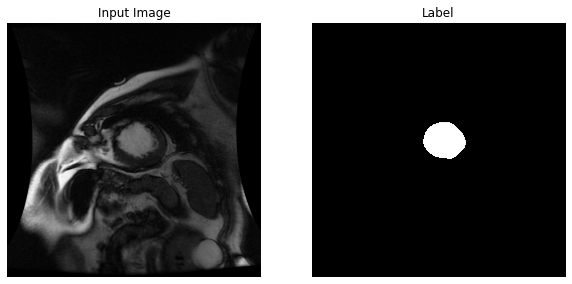

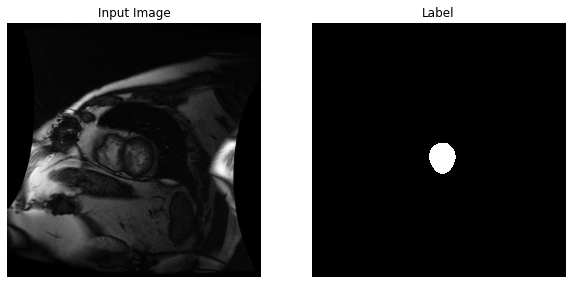

In [12]:
# display an image and label from the training set
for image, label in train.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

If we run the same thing again, we'll get two new sets of images from our dataset.

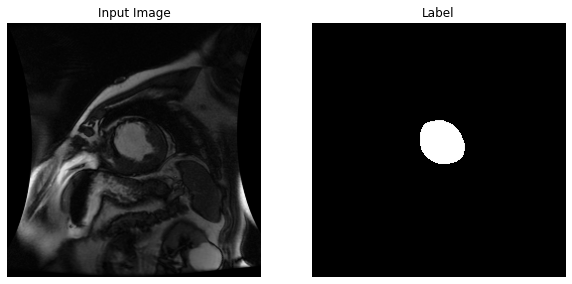

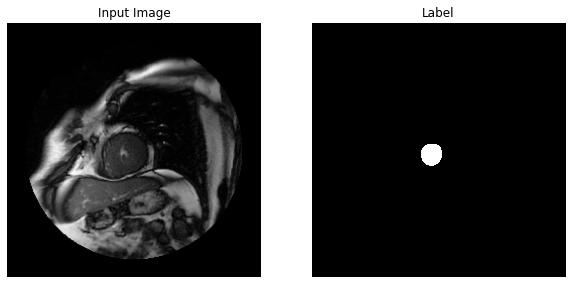

In [13]:
# display an image and label from the test set
for image, label in val.take(2):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

# Task 1 -- One Hidden Layer

![NN](images/NN.png)

## Build the Keras Model

The first task we'll consider will be to create, train and evaluate a fully-connected neural network with one hidden layer:

* The input to the neural network will be the value of each pixel, i.e., a size 256 x 256 x 1 (or 65,536) array. The `X 1` is the number of color channels. Since the images are black and white, we'll only use 1, but if it was color, we might use `X 3` for the red, green, and blue in [RGB](https://www.w3schools.com/colors/colors_rgb.asp). The following Dense layer expects a vector, not a matrix, so we'll [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the incoming image.
* The hidden [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer will have a size that you can adjust to any positive integer.
* the output will have 256 x 256 x 2 values, i.e., each input pixel can be in either one of two classes so the output value associated with each pixel will be the probability that the pixel is in that particular class.  In our case the two classes are LV or not. Then, we'll [Reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape) it into a 256 x 256 x 2 matrix so we can see the result as an image.

We'll compute the loss via a TensorFlow function called [`sparse_softmax_cross_entropy_with_logits`](https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits) which simply combines the softmax with the cross entropy calculation into one function call.

In [ ]:
tf.keras.backend.clear_session()

# set up the model architecture
model = tf.keras.models.Sequential([
    Flatten(input_shape=[256, 256, 1]),
    Dense(64, activation='relu'),
    Dense(256*256*2, activation='softmax'),
    Reshape((256, 256, 2))
])

# specify how to train the model with algorithm, the loss function and metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

We can print out the model architecture using the [`model.summary`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) method to verify the structure of out model and observse it's size.

In [ ]:
# print out the summary of the model
model.summary()

We can also plot the modeul with the [`plot_model`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model) method which allows us to visually see the structure, which is especially useful when using the Functional API

In [ ]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

Before we get to training, let's build some functions to visualize how the model is learning. First, we'll create a function, `create_mask`, which will take one of our validaiton results and return it as a 256 x 256 x 1 array. Each cell will be either a 1, meaning an LV pixel, or 0, meaning no LV.

We'll do this by using the [`tf.argmax`](https://www.tensorflow.org/api_docs/python/tf/math/argmax) function and observing the last dimension, `axis=-1`. We effectively have an image of 2 channels with the probability of no-LV on the 0th channel and the probability LV on the 1st channel. [`tf.argmax`](https://www.tensorflow.org/api_docs/python/tf/math/argmax) will then return the index of the channel with the higher probability, resulting in a 1 X 256 X 256 array.

In order to get it into the 256 X 256 X 1 shape that our plotting tools expect, we'll append a [new axis](https://www.tensorflow.org/api_docs/python/tf/Tensor) on the end and select the first and only element.

In [19]:
# function to take a prediction from the model and output an image for display
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

With this, we'll make a function to diplay our predictions, `show_predictions`. If we feed it a dataset, it will display our model predictions on each image in the dataset. Otherwise, it will run our `sample_image` through our model.

In [20]:
# helper function to show the image, the label and the prediction
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, label in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], label[0], create_mask(pred_mask)])
    else:
        prediction = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display([sample_image, sample_label, prediction])

In [ ]:
# show a predection, as an example
show_predictions(test_dataset)

Next, we'll create our own custom [Keras Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback), so that at the end of each epoch, we'll see what our model predicts on our `sample_image`. We'll also set up a [TensorBoard callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) so we can graph our training results.

In [17]:
# define a callback that shows image predictions on the test set
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# setup a tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

## Train the Model

Execute the below cell to train the model. For each epoch, it will display the `loss`, `accuracy`, our `sample_image`, the true label, and the predicted label. The test results for our validation data will then be displayed. It will similarly have `loss` and `accuracy`, but it will also have `val_loss` and `val_accuracy` to see how our model performed against data it did not train on. If our training `accuracy` is low, but out `val_accuracy` is high, that would be a sign of [overfitting](https://en.wikipedia.org/wiki/Overfitting)

In [ ]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

In [ ]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


## Evaluate the Model

When first trainging, the model predicts white noise as it is essentially assigning a random probability to each pixel, but as it learns, it eventuals centers in on the same white dot as in our label, albeit it produces a fuzzy mimic.


In [ ]:
model.evaluate(test_dataset)

### TensorBoard
We can also see these results in TensorBoard. To use [TensorBoard in a notebook](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks), we'll first need to load the TensorBoard extension.

In [ ]:
%load_ext tensorboard

Then, we can run it with `%tensorboard --logdir <log_directory>` where `<log_directory>` is the same log directory defined in `tensorboard_callback`.

In [ ]:
%tensorboard --logdir logs

TensorBoard can run while models are training as a debugging tool. For instance, if the validation loss starts to increase while the train loss is decreasing, that could be a sign of overfitting and that training should stop to investigate.

We'll leave the above TensorBoard up for the rest of the lab. Check back during other model runs to see how they compare.

So how are our numbers? The accuracy should be over 90%, which sounds great! Let's take a moment to look at some more sample predictions.

In [ ]:
show_predictions(test_dataset, 5)

Our model is using the same prediction no matter what the input is. How did this happen? Think about it for now, we'll address this soon.

## Topics not covered in detail

We skipped over a number of topics that we'll mention for completeness, but won't discuss in detail.  
* We assumed all the data was setup for us already.  As previously shown earlier, we're using TFRecords file data format that has already been setup for us.  
* We are using a TensorFlow mechanism using multiple threads to read the data from those files.  This allows us to use built-in TensorFlow functions to randomize the data, as well as handle things like `batch_size` and `num_epochs` automatically.

# Task 2 -- Convolutional Neural Network (CNN)

Our second task will be to convert our model to a more sophisticated network that includes more layers and types than above.  The previous example focused on each individual pixel but had no way to account for the fact that the regions of interest are likely larger than a single pixel.  We'd like to capture small regions of interest as well and for that we'll utilize convolutional layers which can capture larger receptive fields.  

We'll also add pooling layers which down-sample the data while attempting to retain most of the information.  This eliminates some computational complexity.

Up to this point we've described layers that are commonly associated with image recognition neural networks, where the number of output nodes is equal to the number of classes.  Recall that we're doing more than classifying the image; we're classifying each pixel in the image so our output size will be the number of classes (2) times the number of pixels (256 x 256).  Additionally the spatial location of the output nodes are important as well, since each pixel has an associated probability that it's part of LV (or not). 

CNN's are well-established as excellent choices for image recognition or classification tasks.  Our task in this lab is segmentation, which is related to classification in a sense.  We are classifying each pixel in the image, rather than the entire image altogether.  So the question becomes, can we utilize the same type of CNN that is already shown to do very well on image recognition, for our task of segmentation?  It turns out that we can make some modifications to CNN models to do this.

We can accomplish this by using a standard image recognition neural network, and replacing the fully-connected layers (typically the last few layers) with deconvolution layers (arguably more accurately called [transpose convolution](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose) layers)

Deconvolution is an upsampling method that brings a smaller image data set back up to it's original size for final pixel classification.  There are a few good resources [[4](#4), [5](#5), [6](#6)] that we'd recommend on this topic.  When modifying a CNN to adapt it to segmentation the resulting neural network is commonly called a fully convolutional network, or FCN.

It can be helpful to visualize how the input data (in our case a tensor of size 256 x 256 x 1) "flows" through the graph, i.e., how the data is transformed via the different operations of convolution, pooling and such.  The figure below represents the transformations that our data will undergo in the next task.

![FCN](images/FCN.png)

The network represented by the figure above is similar to the network that's found in ref [[7](#7)].  It consists of convolution layers, pooling layers, and a final deconvolution layer, with the input image being transformed as indicated in the image.  

This task requires you to finish the neural network below and then run the training.  To accomplish this edit the Sequential model and replace all the instances of `FIXME` with code.  There are comments in the code to help you and you can use the following network structure to help as well.  The names of the layers will make more sense as you examine and complete the code.

1. Convolution1, 5 x 5 kernel, stride 2
2. Maxpooling1, 2 x 2 window, stride 2
3. Convolution2, 5 x 5 kernel, stride 2
4. Maxpooling2, 2 x 2 window, stride 2
5. Convolution3, 3 x 3 kernel, stride 1
6. Convolution4, 3 x 3 kernel, stride 1
7. Score_classes, 1x1 kernel, stride 1
8. Upscore (deconvolution), 31 x 31 kernel, stride 16

In [ ]:
tf.keras.backend.clear_session()

layers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=100,
           kernel_size=FIXME,
           strides=FIXME,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=200,
           kernel_size=FIXME,
           strides=FIXME,
           padding="same",
           activation=tf.nn.relu),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=300,
           kernel_size=FIXME,
           strides=FIXME,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=300,
           kernel_size=FIXME,
           strides=FIXME,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=2,
           kernel_size=FIXME,
           strides=FIXME,
           padding="same",
           activation=tf.nn.relu),
    Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")
]

model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

If a hint is needed, feel free to look at the <a href="Solution.ipynb">Solution notebook</a>.

<sub>Click above for hint.</sub>

As before, let's see the summary and plot of the model.

In [ ]:
# print out the summary of the model
model.summary()

In [ ]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# show a predection, as an example
show_predictions(test_dataset)

Once you complete the code, you can begin running training using the box below and visualizing your results via the TensorBoard browser window you opened in the previous task.  If you don't immediately see your results, you may have to wait a short time for TensorBoard to recognize that there are new graphs to visualize.  You may also have to refresh your browser.

In [ ]:
# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

What's the best accuracy you can achieve?  As an example, with 1 epoch of training we achieved an accuracy of 56.7%:

```
OUTPUT: 2017-01-27 17:41:52.015709: precision = 0.567
```

When increasing the number of epochs to 10, we obtained a much higher accuracy of this:

```
OUTPUT: 2017-01-27 17:47:59.604529: precision = 0.983
```

As you can see when we increase the training epochs we see a significant increase in accuracy.  In fact an accuracy of 98.3% is quite good.  Is this accuracy good enough?  Are we finished?

In [ ]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_dataset)

In [ ]:
# show predictions from the test data set that has NOT been used for training.
show_predictions(test_dataset, 5)

# Accuracy

As part of the discussion of our accuracy we need to take a step back and consider fully what exactly we are assessing when we check accuracy.  Our current accuracy metric is simply telling us how many pixels we are computing correctly.  So in the case above with 30 epochs, we are correctly predicting the value of a pixel 98.3% of the time.  However, notice from the images above that the region of LV is typically quite small compared to the entire image size.  This leads to a problem called class imbalance, i.e., one class is much more probable than the other class.  In our case, if we simply designed a network to output the class notLV for every output pixel, we'd still have something like 95% accuracy.  But that would be a seemingly useless network.  What we need is an accuracy metric that gives us some indication of how well our network segments the left ventricle irrespective of the imbalance.

# Task 3 -- CNN with Dice Metric Loss

One metric we can use to more accurately determine how well our network is segmenting LV is called the Dice metric or Sorensen-Dice coefficient, among other names.  This is a metric to compare the similarity of two samples.  In our case we'll use it to compare the two areas of interest, i.e., the area of the expertly-labelled contour and the area of our predicted contour.  The formula for computing the Dice metric is:

$$ \frac{2A_{nl}}{A_{n} + A_{l}} $$

where $A_n$ is the area of the contour predicted by our neural network, $A_l$ is the area of the contour from the expertly-segmented label and $A_{nl}$ is the intersection of the two, i.e., the area of the contour that is predicted correctly by the network.  1.0 means perfect score.

This metric will more accurately inform us of how well our network is segmenting the LV because the class imbalance problem is negated.  Since we're trying to determine how much area is contained in a particular contour, we can simply count the pixels to give us the area.

In [56]:
def dice_coef(y_true, y_pred, smooth=1):
    indices = K.argmax(y_pred, 3)
    indices = K.reshape(indices, [-1, 256, 256, 1])

    true_cast = y_true
    indices_cast = K.cast(indices, dtype='float32')

    axis = [1, 2, 3]
    intersection = K.sum(true_cast * indices_cast, axis=axis)
    union = K.sum(true_cast, axis=axis) + K.sum(indices_cast, axis=axis)
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)

    return dice

Note: We are still using cross entropy for the loss function during training but are now evaluating the accuracy using the Dice metric.

Run the training by executing the cell below with 1 epoch and then check your accuracy by running the evaluation (two cells down). Then try running the training with 30 epochs. This is similar to what you may have done with the previous task. Check your accuracy after 30 epochs as well. Visualize the results in TensorBoard.

In [ ]:
# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
tf.keras.backend.clear_session() 
model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[dice_coef,'accuracy'])

In [ ]:
 # setup and run the model
EPOCHS = 30
STEPS_PER_EPOCH = len(list(parsed_training_dataset))

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [ ]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In a prior run we obtained 

```
OUTPUT: 2017-01-27 18:44:04.103153: Dice metric = 0.9176
```

for 1 epoch.  If you try with 30 epochs you might get around 99.9% accuracy.

```
OUTPUT: 2017-01-27 18:56:45.501209: Dice metric = 0.9583
```

With a more realistic accuracy metric, you can see that there is some room for improvement in the neural network.

# Parameter Search

At this point we've created a neural network that we think has the right structure to do a reasonably good job and we've used an accuracy metric that correctly tells us how well our network is learning the segmentation task.  But up to this point our evaluation accuracy hasn't been as high as we'd like.  The next thing to consider is that we should try to search the parameter space a bit more.  Up to now we've changed the number of epochs but that's all we've adjusted.  There are a few more parameters we can test that could push our accuracy score higher.

When it comes to image segmentation, there are many types of [metrics](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2) and [loss functions](https://www.tensorflow.org/api_docs/python/tf/keras/losses). For this demo, [Categorical Crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) was effective as it can apply near infinite loss for innacurate predictions from a model, but it's worth exploring when TensorFlow has to offer.

We could also alter the structure of our model such as:
 - changing the number of layers
   - changing the proportion of Conv2D, MaxPool2D and Conv2DTranspose layers
 - changing the number and size of the filters
 - chanfing the stride of the filters

Play around with these values by running training in the next cell and see if you can come up with better accuracy than seen earlier. Feel free to use and earlier model as a starting point. We don't recommend running more than 100 epochs due to time constraints of the lab, but in production you would quite likely run a lot more epochs.  

Conveniently, if you start a training run and realize the number of epochs is too large you can kill that run and still test the model by running the evaluation (two cells down).  TensorFlow has checkpointing abilities that snapshot the model periodically so the most recent snapshot will still be retained after you kill the training run.

In [61]:
layers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=128,
           kernel_size=7,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(
           filters=256,
           kernel_size=3,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv2"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2DTranspose(filters=2, kernel_size=64, strides=16, padding="same")
]

# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

tf.keras.backend.clear_session()
model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[dice_coef,'accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 128, 128, 128)     6400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 256, 256, 2)       2097154   
Total params: 2,398,722
Trainable params: 2,398,722
Non-trainable params: 0
_________________________________________________________________


Train for 234 steps
Epoch 1/30
228/234 [============================>.] - ETA: 0s - loss: 0.0780 - dice_coef: 0.0792 - accuracy: 0.9820

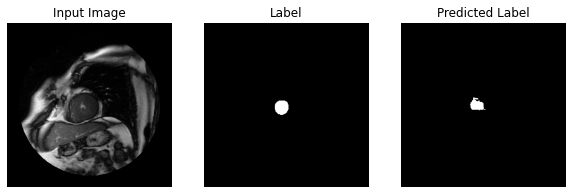


Sample Prediction after epoch 1

234/234 [==============================] - 2s 9ms/step - loss: 0.0772 - dice_coef: 0.0885 - accuracy: 0.9821 - val_loss: 0.0426 - val_dice_coef: 0.2947 - val_accuracy: 0.9862
Epoch 2/30
231/234 [============================>.] - ETA: 0s - loss: 0.0379 - dice_coef: 0.3514 - accuracy: 0.9872

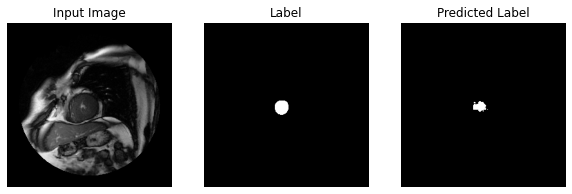


Sample Prediction after epoch 2

234/234 [==============================] - 1s 6ms/step - loss: 0.0378 - dice_coef: 0.3507 - accuracy: 0.9873 - val_loss: 0.0412 - val_dice_coef: 0.2810 - val_accuracy: 0.9866
Epoch 3/30
231/234 [============================>.] - ETA: 0s - loss: 0.0319 - dice_coef: 0.4937 - accuracy: 0.9891

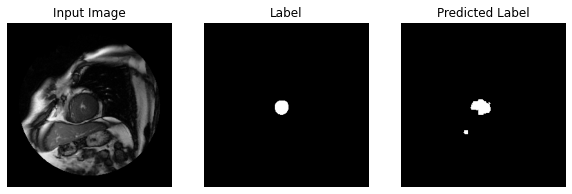


Sample Prediction after epoch 3

234/234 [==============================] - 1s 6ms/step - loss: 0.0318 - dice_coef: 0.4955 - accuracy: 0.9891 - val_loss: 0.0304 - val_dice_coef: 0.5280 - val_accuracy: 0.9895
Epoch 4/30
231/234 [============================>.] - ETA: 0s - loss: 0.0276 - dice_coef: 0.5461 - accuracy: 0.9901

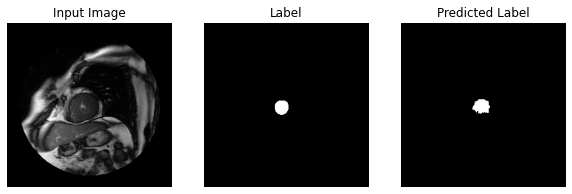


Sample Prediction after epoch 4

234/234 [==============================] - 1s 6ms/step - loss: 0.0276 - dice_coef: 0.5484 - accuracy: 0.9902 - val_loss: 0.0271 - val_dice_coef: 0.6010 - val_accuracy: 0.9907
Epoch 5/30
231/234 [============================>.] - ETA: 0s - loss: 0.0229 - dice_coef: 0.6442 - accuracy: 0.9918

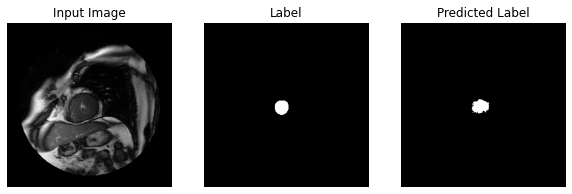


Sample Prediction after epoch 5

234/234 [==============================] - 1s 6ms/step - loss: 0.0228 - dice_coef: 0.6463 - accuracy: 0.9919 - val_loss: 0.0234 - val_dice_coef: 0.6474 - val_accuracy: 0.9919
Epoch 6/30
231/234 [============================>.] - ETA: 0s - loss: 0.0198 - dice_coef: 0.6959 - accuracy: 0.9928

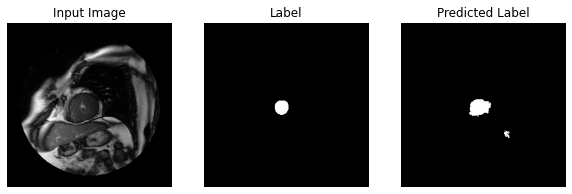


Sample Prediction after epoch 6

234/234 [==============================] - 1s 6ms/step - loss: 0.0198 - dice_coef: 0.6970 - accuracy: 0.9928 - val_loss: 0.0217 - val_dice_coef: 0.7130 - val_accuracy: 0.9925
Epoch 7/30
231/234 [============================>.] - ETA: 0s - loss: 0.0175 - dice_coef: 0.7116 - accuracy: 0.9935

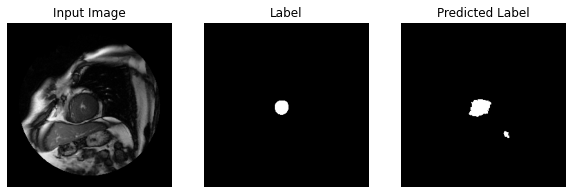


Sample Prediction after epoch 7

234/234 [==============================] - 2s 7ms/step - loss: 0.0175 - dice_coef: 0.7138 - accuracy: 0.9935 - val_loss: 0.0211 - val_dice_coef: 0.7239 - val_accuracy: 0.9928
Epoch 8/30
231/234 [============================>.] - ETA: 0s - loss: 0.0155 - dice_coef: 0.7488 - accuracy: 0.9943

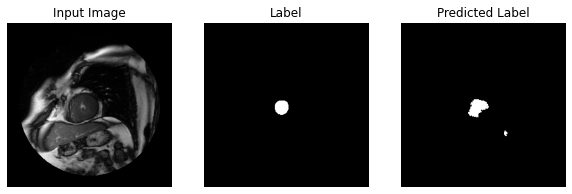


Sample Prediction after epoch 8

234/234 [==============================] - 1s 6ms/step - loss: 0.0155 - dice_coef: 0.7504 - accuracy: 0.9943 - val_loss: 0.0162 - val_dice_coef: 0.7388 - val_accuracy: 0.9942
Epoch 9/30
231/234 [============================>.] - ETA: 0s - loss: 0.0127 - dice_coef: 0.7926 - accuracy: 0.9952

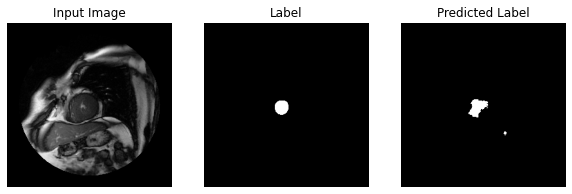


Sample Prediction after epoch 9

234/234 [==============================] - 1s 6ms/step - loss: 0.0127 - dice_coef: 0.7935 - accuracy: 0.9952 - val_loss: 0.0147 - val_dice_coef: 0.7501 - val_accuracy: 0.9946
Epoch 10/30
231/234 [============================>.] - ETA: 0s - loss: 0.0110 - dice_coef: 0.8156 - accuracy: 0.9959

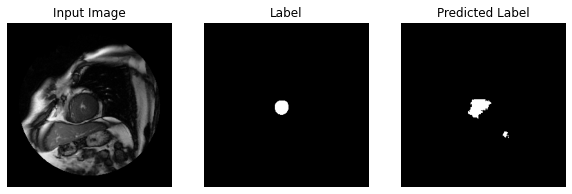


Sample Prediction after epoch 10

234/234 [==============================] - 1s 6ms/step - loss: 0.0110 - dice_coef: 0.8160 - accuracy: 0.9959 - val_loss: 0.0133 - val_dice_coef: 0.7956 - val_accuracy: 0.9953
Epoch 11/30
231/234 [============================>.] - ETA: 0s - loss: 0.0094 - dice_coef: 0.8392 - accuracy: 0.9965

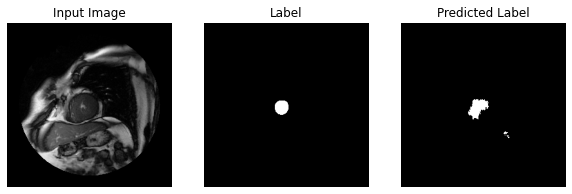


Sample Prediction after epoch 11

234/234 [==============================] - 1s 6ms/step - loss: 0.0094 - dice_coef: 0.8398 - accuracy: 0.9965 - val_loss: 0.0125 - val_dice_coef: 0.7909 - val_accuracy: 0.9955
Epoch 12/30
231/234 [============================>.] - ETA: 0s - loss: 0.0084 - dice_coef: 0.8612 - accuracy: 0.9968

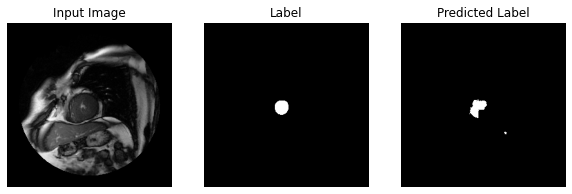


Sample Prediction after epoch 12

234/234 [==============================] - 1s 6ms/step - loss: 0.0085 - dice_coef: 0.8611 - accuracy: 0.9968 - val_loss: 0.0124 - val_dice_coef: 0.7894 - val_accuracy: 0.9956
Epoch 13/30
231/234 [============================>.] - ETA: 0s - loss: 0.0071 - dice_coef: 0.8836 - accuracy: 0.9974

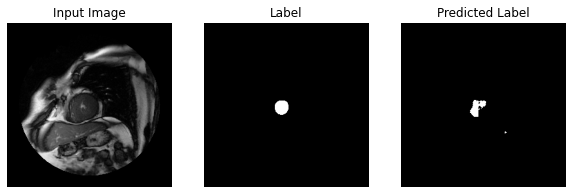


Sample Prediction after epoch 13

234/234 [==============================] - 1s 6ms/step - loss: 0.0070 - dice_coef: 0.8843 - accuracy: 0.9974 - val_loss: 0.0136 - val_dice_coef: 0.7560 - val_accuracy: 0.9953
Epoch 14/30
231/234 [============================>.] - ETA: 0s - loss: 0.0066 - dice_coef: 0.8906 - accuracy: 0.9975

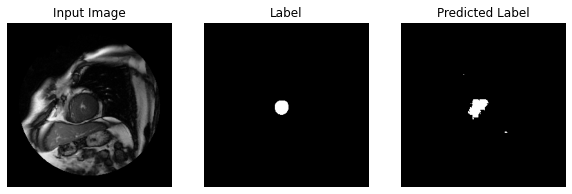


Sample Prediction after epoch 14

234/234 [==============================] - 1s 6ms/step - loss: 0.0065 - dice_coef: 0.8913 - accuracy: 0.9975 - val_loss: 0.0114 - val_dice_coef: 0.8112 - val_accuracy: 0.9960
Epoch 15/30
231/234 [============================>.] - ETA: 0s - loss: 0.0054 - dice_coef: 0.9132 - accuracy: 0.9980

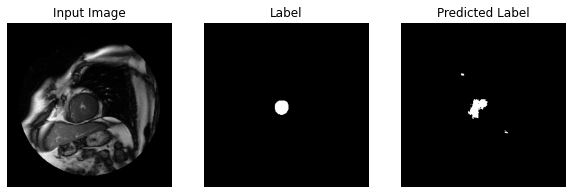


Sample Prediction after epoch 15

234/234 [==============================] - 1s 6ms/step - loss: 0.0055 - dice_coef: 0.9130 - accuracy: 0.9980 - val_loss: 0.0110 - val_dice_coef: 0.8103 - val_accuracy: 0.9963
Epoch 16/30
231/234 [============================>.] - ETA: 0s - loss: 0.0047 - dice_coef: 0.9256 - accuracy: 0.9983

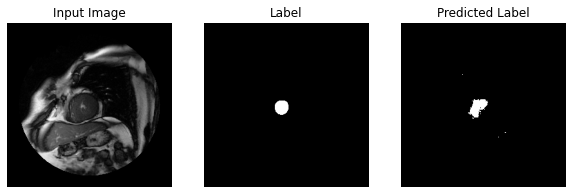


Sample Prediction after epoch 16

234/234 [==============================] - 1s 6ms/step - loss: 0.0047 - dice_coef: 0.9258 - accuracy: 0.9983 - val_loss: 0.0111 - val_dice_coef: 0.8242 - val_accuracy: 0.9962
Epoch 17/30
231/234 [============================>.] - ETA: 0s - loss: 0.0043 - dice_coef: 0.9247 - accuracy: 0.9984

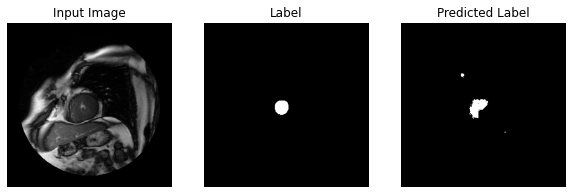


Sample Prediction after epoch 17

234/234 [==============================] - 2s 7ms/step - loss: 0.0043 - dice_coef: 0.9244 - accuracy: 0.9984 - val_loss: 0.0113 - val_dice_coef: 0.8199 - val_accuracy: 0.9962
Epoch 18/30
231/234 [============================>.] - ETA: 0s - loss: 0.0033 - dice_coef: 0.9494 - accuracy: 0.9988

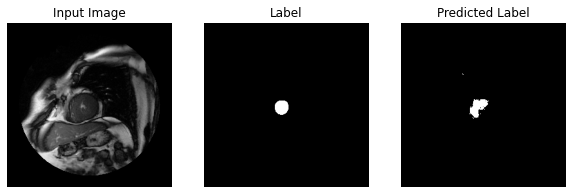


Sample Prediction after epoch 18

234/234 [==============================] - 1s 6ms/step - loss: 0.0033 - dice_coef: 0.9493 - accuracy: 0.9988 - val_loss: 0.0109 - val_dice_coef: 0.8314 - val_accuracy: 0.9965
Epoch 19/30
231/234 [============================>.] - ETA: 0s - loss: 0.0030 - dice_coef: 0.9551 - accuracy: 0.9989

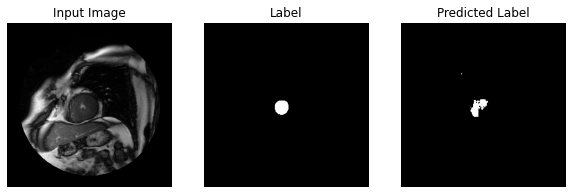


Sample Prediction after epoch 19

234/234 [==============================] - 1s 6ms/step - loss: 0.0030 - dice_coef: 0.9548 - accuracy: 0.9989 - val_loss: 0.0137 - val_dice_coef: 0.8036 - val_accuracy: 0.9959
Epoch 20/30
231/234 [============================>.] - ETA: 0s - loss: 0.0026 - dice_coef: 0.9634 - accuracy: 0.9991

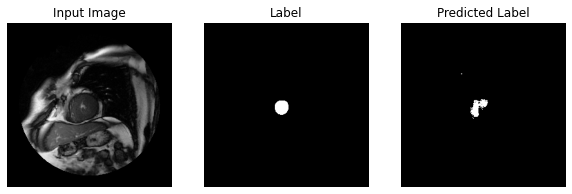


Sample Prediction after epoch 20

234/234 [==============================] - 1s 6ms/step - loss: 0.0026 - dice_coef: 0.9629 - accuracy: 0.9991 - val_loss: 0.0147 - val_dice_coef: 0.7912 - val_accuracy: 0.9958
Epoch 21/30
231/234 [============================>.] - ETA: 0s - loss: 0.0024 - dice_coef: 0.9639 - accuracy: 0.9992

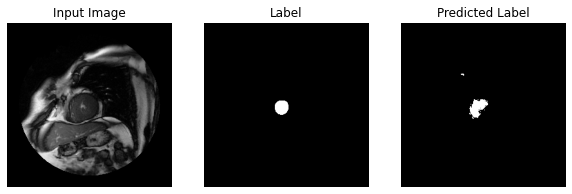


Sample Prediction after epoch 21

234/234 [==============================] - 1s 6ms/step - loss: 0.0024 - dice_coef: 0.9642 - accuracy: 0.9992 - val_loss: 0.0120 - val_dice_coef: 0.8309 - val_accuracy: 0.9964
Epoch 22/30
231/234 [============================>.] - ETA: 0s - loss: 0.0019 - dice_coef: 0.9768 - accuracy: 0.9994

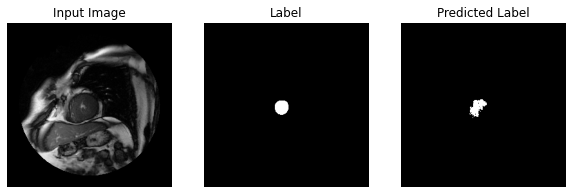


Sample Prediction after epoch 22

234/234 [==============================] - 1s 6ms/step - loss: 0.0019 - dice_coef: 0.9770 - accuracy: 0.9994 - val_loss: 0.0156 - val_dice_coef: 0.7983 - val_accuracy: 0.9961
Epoch 23/30
231/234 [============================>.] - ETA: 0s - loss: 0.0018 - dice_coef: 0.9767 - accuracy: 0.9994

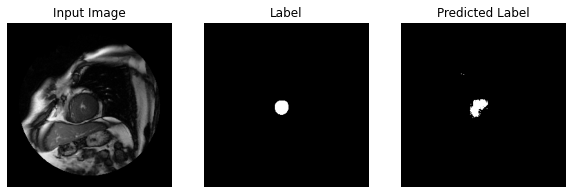


Sample Prediction after epoch 23

234/234 [==============================] - 1s 6ms/step - loss: 0.0018 - dice_coef: 0.9768 - accuracy: 0.9994 - val_loss: 0.0132 - val_dice_coef: 0.8269 - val_accuracy: 0.9964
Epoch 24/30
231/234 [============================>.] - ETA: 0s - loss: 0.0015 - dice_coef: 0.9810 - accuracy: 0.9995

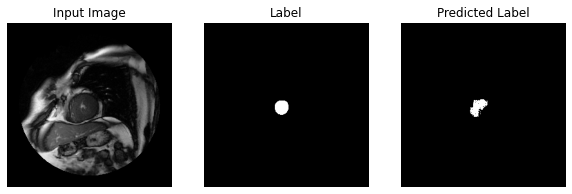


Sample Prediction after epoch 24

234/234 [==============================] - 1s 6ms/step - loss: 0.0015 - dice_coef: 0.9810 - accuracy: 0.9995 - val_loss: 0.0147 - val_dice_coef: 0.8166 - val_accuracy: 0.9963
Epoch 25/30
231/234 [============================>.] - ETA: 0s - loss: 0.0010 - dice_coef: 0.9901 - accuracy: 0.9997

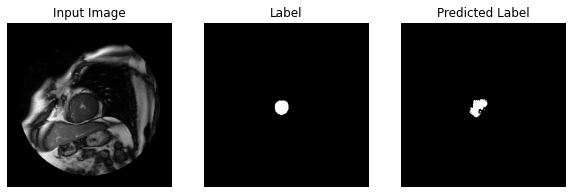


Sample Prediction after epoch 25

234/234 [==============================] - 1s 6ms/step - loss: 0.0010 - dice_coef: 0.9900 - accuracy: 0.9997 - val_loss: 0.0148 - val_dice_coef: 0.8255 - val_accuracy: 0.9964
Epoch 26/30
231/234 [============================>.] - ETA: 0s - loss: 9.5189e-04 - dice_coef: 0.9908 - accuracy: 0.9997

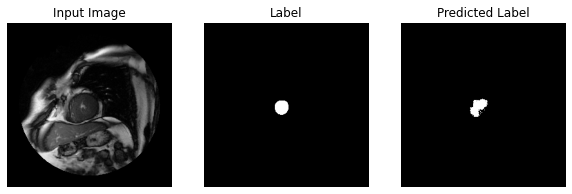


Sample Prediction after epoch 26

234/234 [==============================] - 1s 6ms/step - loss: 9.6157e-04 - dice_coef: 0.9907 - accuracy: 0.9997 - val_loss: 0.0165 - val_dice_coef: 0.8196 - val_accuracy: 0.9963
Epoch 27/30
231/234 [============================>.] - ETA: 0s - loss: 8.1932e-04 - dice_coef: 0.9902 - accuracy: 0.9998

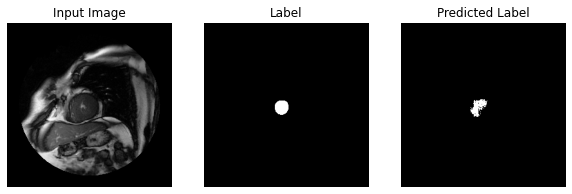


Sample Prediction after epoch 27

234/234 [==============================] - 2s 7ms/step - loss: 8.3189e-04 - dice_coef: 0.9901 - accuracy: 0.9998 - val_loss: 0.0188 - val_dice_coef: 0.8029 - val_accuracy: 0.9960
Epoch 28/30
231/234 [============================>.] - ETA: 0s - loss: 9.1358e-04 - dice_coef: 0.9860 - accuracy: 0.9998

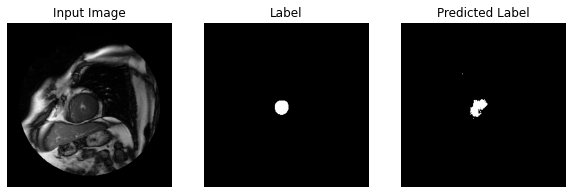


Sample Prediction after epoch 28

234/234 [==============================] - 1s 6ms/step - loss: 9.1126e-04 - dice_coef: 0.9860 - accuracy: 0.9998 - val_loss: 0.0185 - val_dice_coef: 0.8021 - val_accuracy: 0.9961
Epoch 29/30
231/234 [============================>.] - ETA: 0s - loss: 7.3772e-04 - dice_coef: 0.9913 - accuracy: 0.9998

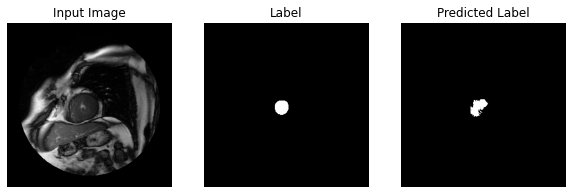


Sample Prediction after epoch 29

234/234 [==============================] - 1s 6ms/step - loss: 7.3113e-04 - dice_coef: 0.9914 - accuracy: 0.9998 - val_loss: 0.0180 - val_dice_coef: 0.8211 - val_accuracy: 0.9963
Epoch 30/30
231/234 [============================>.] - ETA: 0s - loss: 7.6424e-04 - dice_coef: 0.9914 - accuracy: 0.9998

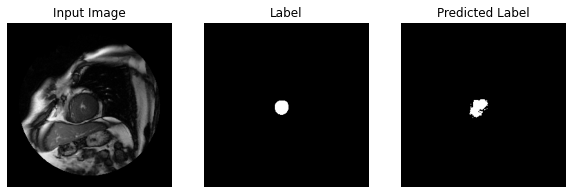


Sample Prediction after epoch 30

234/234 [==============================] - 1s 6ms/step - loss: 7.6172e-04 - dice_coef: 0.9915 - accuracy: 0.9998 - val_loss: 0.0173 - val_dice_coef: 0.8285 - val_accuracy: 0.9965


In [62]:
EPOCHS = 30
STEPS_PER_EPOCH = len(list(parsed_training_dataset))

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_dataset,
                          
                          callbacks=[DisplayCallback()])

<a id="References"></a>
# References

<a id="1"></a>
[1] Sunnybrook cardiac images from earlier competition https://smial.sri.utoronto.ca/LV_Challenge/Data.html

<a id="2"></a>
[2] This "Sunnybrook Cardiac MR Database" is made available under the CC0 1.0 Universal license described above, and with more detail here: https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/

<a id="3"></a>
[3] Attribution:
Radau P, Lu Y, Connelly K, Paul G, Dick AJ, Wright GA. "Evaluation Framework for Algorithms Segmenting Short Axis Cardiac MRI." The MIDAS Journal -Cardiac MR Left Ventricle Segmentation Challenge, http://hdl.handle.net/10380/3070

<a id="4"></a>
[4] http://fcn.berkeleyvision.org/

<a id="5"></a>
[5] Long, Shelhamer, Darrell; "Fully Convoutional Networks for Semantic Segmentation", CVPR 2015.

<a id="6"></a>
[6] Zeiler, Krishnan, Taylor, Fergus; "Deconvolutional Networks", CVPR 2010.

<a id="7"></a>
[7] https://www.kaggle.com/c/second-annual-data-science-bowl/details/deep-learning-tutorial
